In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fft
from scipy import stats
import scipy
import math
from matplotlib.gridspec import GridSpec
import statsmodels.tsa.stattools
import pandas as pd


plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({'font.family': 'serif',
                     'text.usetex': True,
                     'font.serif': ['Helvetica'],
                     'font.size': 8,
                     'axes.labelsize': 10,
                     'axes.titlesize': 12,
                     'figure.titlesize': 14})
props = dict(edgecolor="none", facecolor='white', alpha=0)


In [21]:
length = 10000
lengthfGn = length
OneOverDelta_t = 10
Delta_t = 1/OneOverDelta_t
band_size = 10
band_sizefGn = band_size
freqs = 2*math.pi*fft.fftfreq(2*length*OneOverDelta_t*band_size,Delta_t)[:length*OneOverDelta_t*band_size:band_size]
freqsfGn = 2*math.pi*fft.fftfreq(2*lengthfGn*OneOverDelta_t*band_sizefGn,Delta_t)[:lengthfGn*OneOverDelta_t*band_sizefGn:band_sizefGn]
theta = 1
sigma = 1
oversampling = 10

nlags = 10
lags = range(nlags)
lags_th = np.arange(0,nlags,0.01)

H=0.9

In [22]:
"""
Created on Fri Aug 14 00:06:57 2020

@author: Justin Yu

Implementation of Fractional Brownian Motion, Hosking's method.
"""
def hosking(T, N, H):
    '''
    Generates sample paths of fractional Brownian Motion using the Davies Harte method
    
    args:
        T:      length of time (in years)
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    gamma = lambda k,H: 0.5*(np.abs(k-1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k+1)**(2*H))  
    
    X = [np.random.standard_normal()]
    mu = [gamma(1,H)*X[0]]
    sigsq = [1 - (gamma(1,H)**2)]
    tau = [gamma(1,H)**2]
    
    d = np.array([gamma(1,H)])
    
    for n in range(1, N):
        
        F = np.rot90(np.identity(n+1))
        c = np.array([gamma(k+1,H) for k in range(0,n+1)])
                
        # sigma(n+1)**2
        s = sigsq[n-1] - ((gamma(n+1,H) - tau[n-1])**2)/sigsq[n-1]
        
        # d(n+1)
        phi = (gamma(n+1,H) - tau[n-1])/sigsq[n-1]
        d = d - phi*d[::-1]
        d = np.append(d, phi)        
        
        # mu(n+1) and tau(n+1)
        Xn1 = mu[n-1] + sigsq[n-1]*np.random.standard_normal()
        
        X.append(Xn1)
        sigsq.append(s)
        mu.append(d @ X[::-1])
        tau.append(c @ F @ d)
    
    fBm = np.cumsum(X)*(N**(-H))    
    return (T**H)*fBm


# -*- coding: utf-8 -*-
"""
Created on Fri Jul  3 15:26:14 2020

@author: Justin Yu, M.S. Financial Engineering, Stevens Institute of Technology

Implementation of Fractional Brownian Motion, Davies Harte Method
"""

import numpy as np

def davies_harte(T, N, H):
    '''
    Generates sample paths of fractional Brownian Motion using the Davies Harte method
    
    args:
        T:      length of time (in years)
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    gamma = lambda k,H: 0.5*(np.abs(k-1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k+1)**(2*H))  
    g = [gamma(k,H) for k in range(0,N)];    r = g + [0] + g[::-1][0:N-1]

    # Step 1 (eigenvalues)
    j = np.arange(0,2*N);   k = 2*N-1
    lk = np.fft.fft(r*np.exp(2*np.pi*complex(0,1)*k*j*(1/(2*N))))[::-1]

    # Step 2 (get random variables)
    Vj = np.zeros((2*N,2), dtype=np.complex64); 
    Vj[0,0] = np.random.standard_normal();  Vj[N,0] = np.random.standard_normal()
    
    for i in range(1,N):
        Vj1 = np.random.standard_normal();    Vj2 = np.random.standard_normal()
        Vj[i][0] = Vj1; Vj[i][1] = Vj2; Vj[2*N-i][0] = Vj1;    Vj[2*N-i][1] = Vj2
    
    # Step 3 (compute Z)
    wk = np.zeros(2*N, dtype=np.complex64)   
    wk[0] = np.sqrt((lk[0]/(2*N)))*Vj[0][0];          
    wk[1:N] = np.sqrt(lk[1:N]/(4*N))*((Vj[1:N].T[0]) + (complex(0,1)*Vj[1:N].T[1]))       
    wk[N] = np.sqrt((lk[0]/(2*N)))*Vj[N][0]       
    wk[N+1:2*N] = np.sqrt(lk[N+1:2*N]/(4*N))*(np.flip(Vj[1:N].T[0]) - (complex(0,1)*np.flip(Vj[1:N].T[1])))
    
    Z = np.fft.fft(wk);     fGn = Z[0:N] 
    fBm = np.cumsum(fGn)*(N**(-H))
    fBm = (T**H)*(fBm)
    path = np.array([0] + list(fBm))
    return path



In [23]:
#Computing the theoretical PSDs of the underlying continuous-time models.
white_th_spec = np.array([sigma**2 for x in freqs])
u_th_spec = np.array([sigma**2/(theta**2+x**2) for x in freqs])
du_th_spec = np.array([sigma**2*x**2/(theta**2+x**2) for x in freqs])
fGn_th_spec = (H*np.pi)**-1*math.gamma(1-2*H)*np.cos(H*np.pi)*np.sin(H*np.pi)*math.gamma(2*H+1)*np.array([(x*2*np.pi)**(1-2*H) for x in freqsfGn])
uH_th_spec = (H*np.pi)**-1*math.gamma(1-2*H)*np.cos(H*np.pi)*np.sin(H*np.pi)*math.gamma(2*H+1)*np.array([sigma**2*(x*2*np.pi)**(1-2*H)/(theta**2+x**2) for x in freqs])
duH_th_spec = (H*np.pi)**-1*math.gamma(1-2*H)*np.cos(H*np.pi)*np.sin(H*np.pi)*math.gamma(2*H+1)*np.array([sigma**2*x**2*(x*2*np.pi)**(1-2*H)/(theta**2+x**2) for x in freqs])

/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_1843/3241871123.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  fGn_th_spec = (H*np.pi)**-1*math.gamma(1-2*H)*np.cos(H*np.pi)*np.sin(H*np.pi)*math.gamma(2*H+1)*np.array([(x*2*np.pi)**(1-2*H) for x in freqsfGn])
/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_1843/3241871123.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  uH_th_spec = (H*np.pi)**-1*math.gamma(1-2*H)*np.cos(H*np.pi)*np.sin(H*np.pi)*math.gamma(2*H+1)*np.array([sigma**2*(x*2*np.pi)**(1-2*H)/(theta**2+x**2) for x in freqs])
/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_1843/3241871123.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  duH_th_spec = (H*np.pi)**-1*math.gamma(1-2*H)*np.cos(H*np.pi)*np.sin(H*np.pi)*math.gamma(2*H+1)*np.array([sigma**2*x**2*(x*2*np.pi)**(1-2*H)/(theta**2+x**2) for x in freqs])
/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_1843/3241871123.py:7

In [24]:
np.random.seed(10)
if 1:
    fBm_sample = np.abs(davies_harte(2*lengthfGn*band_sizefGn,2*lengthfGn*band_sizefGn*OneOverDelta_t,H=H)[:-1])
    pd.Series(fBm_sample).to_csv("fBm.csv")
else:
    fBm_sample = pd.read_csv("fBm.csv",index_col=0).values.flatten()

In [25]:

np.random.seed(1)
#Generating the discrete-time samples of each model. Oversampling is introduced in the integration of the equations to achieve minimal errors from discretising.
white_sample = np.random.normal(0, 1, size=2*length*band_size*OneOverDelta_t*oversampling)
u_sample = [0]
noise_fac = sigma * math.sqrt(1/(2*theta)*(1-math.exp(-2*theta*Delta_t/oversampling)))
for i in range(2*length*band_size*OneOverDelta_t*oversampling - 1):
    u_sample.append(math.exp(-theta*Delta_t/oversampling) * u_sample[-1] + noise_fac*white_sample[i])
u_sample = np.array(u_sample)



#Reversing the oversampling by skipping the respective amount of time-steps.
dw_sample = sigma * np.random.normal(0, np.sqrt(Delta_t), size=2*length*band_size*OneOverDelta_t)
u_sample = np.array([u_sample[i*oversampling] for i in range(2*length*OneOverDelta_t*band_size)])
du_sample = np.diff(u_sample)
du_sample = np.append(du_sample,[0])
#fBm_sample = dw_sample ###
fGn_sample = np.diff(fBm_sample)
fGn_sample = np.append(fGn_sample,[0])

def fourier(array, type):
    if type == "dt":
        return fft.fft(array)[0:math.ceil(len(array) / 2)]*Delta_t**0.5/len(array)**0.5
    elif type == "dY":
        return fft.fft(array)[0:math.ceil(len(array) / 2)]/(len(array)*Delta_t)**0.5

def power_spectrum(array, type):
    return abs(fourier(array, type)**2)

def band_seperation(array, band_size=band_size):
    if band_size > 1:
        return np.array([sum(array[i * band_size:(i + 1) * band_size]) / band_size for i in
                         range(math.ceil(len(array) / band_size))])
    else:
        return array

In [26]:
print(len(u_sample))
#Calculating the sample PSDs.
dw_sample_spec = band_seperation(power_spectrum(dw_sample,"dY"))
u_sample_spec = band_seperation(power_spectrum(u_sample,"dt"))
du_sample_spec = band_seperation(power_spectrum(du_sample,"dY"))
fGn_sample_spec = band_seperation(power_spectrum(fGn_sample,"dY"),band_sizefGn)

2000000


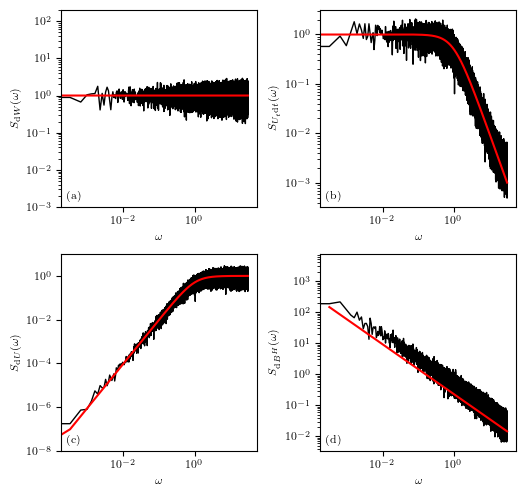

In [27]:
#Plotting Figure 1 in the main text with fGn.
fig, axs = plt.subplots(2,2,figsize=(5.3,5))

samplewidth = 1
samplecolor = "black"
theowidth = 1.5
theocolor = "red"


axs[0,0].set_ylim(10e-4, 200)
axs[0,0].set_ylabel(r"$S_{\mathrm{d}W}(\omega)$")
axs[0,0].set_xlabel(r"$\omega$")
axs[0,0].text(0.03, 0.08, "(a)", transform=axs[0,0].transAxes, verticalalignment='top', bbox=props)
axs[0,0].loglog(freqs, dw_sample_spec,color=samplecolor,linewidth=samplewidth)
axs[0,0].loglog(freqs, white_th_spec,color=theocolor,linewidth=theowidth)

axs[0,1].set_ylabel(r"$S_{U_t\mathrm{d}t}(\omega)$")
axs[0,1].set_xlabel(r"$\omega$")
axs[0,1].text(0.03, 0.08, "(b)", transform=axs[0,1].transAxes, verticalalignment='top', bbox=props)
axs[0,1].loglog(freqs, u_sample_spec,color=samplecolor,linewidth=samplewidth)
axs[0,1].loglog(freqs, u_th_spec ,color=theocolor,linewidth=theowidth)

axs[1,0].set_ylim(10e-9, 10)
axs[1,0].set_ylabel(r"$S_{\mathrm{d}U}(\omega)$")
axs[1,0].set_xlabel(r"$\omega$")
axs[1,0].text(0.03, 0.08, "(c)", transform=axs[1,0].transAxes, verticalalignment='top', bbox=props)
axs[1,0].loglog(freqs, du_sample_spec,color=samplecolor,linewidth=samplewidth)
axs[1,0].loglog(freqs, du_th_spec ,color=theocolor,linewidth=theowidth)

axs[1,1].set_ylabel(r"$S_{\mathrm{d}B^H}(\omega)$")
axs[1,1].set_xlabel(r"$\omega$")
axs[1,1].text(0.03, 0.08, "(d)", transform=axs[1,1].transAxes, verticalalignment='top', bbox=props)
axs[1,1].loglog(freqsfGn, fGn_sample_spec,color=samplecolor,linewidth=samplewidth)
axs[1,1].loglog(freqsfGn, fGn_th_spec ,color=theocolor,linewidth=theowidth)

fig.tight_layout()
plt.savefig("Plots/specs.pdf",dpi=300, bbox_inches='tight')
plt.show()

## Analysing and plotting the autocvariance functions

In [28]:
dw_sample2 = dw_sample[::OneOverDelta_t]*np.sqrt(OneOverDelta_t)
u_sample2 = u_sample[::OneOverDelta_t]
du_sample2 = np.append(np.diff(u_sample2),[0])
fBm_sample2 = fBm_sample[::OneOverDelta_t]
fGn_sample2 = np.append(np.diff(fBm_sample2),[0])

In [29]:
#Computing the theoretical ACFs of the underlying continuous-time models.
white_th_acf = np.array([sigma**2] + [0 for x in lags_th[1:]])
u_th_acf = np.array([sigma**2/(2*theta)*np.exp(-theta*x) for x in lags_th])
du_th_acf = np.array([sigma**2/(2*theta)*(2*np.exp(-theta*x)-np.exp(-theta*np.abs(1-x))-np.exp(-theta*np.abs(1+x))) for x in lags_th])
def fBm_cov(t,s):
    return 1/2*(t**(2*H)+s**(2*H)-np.abs(t-s)**(2*H))
fGn_th_acf = np.array([fBm_cov(1,1+x) + fBm_cov(0,x) - fBm_cov(1,x) - fBm_cov(0,1+x) for x in lags_th])

In [30]:
#Calculating the sample ACFs.
dw_sample_acf = statsmodels.tsa.stattools.acovf(dw_sample2,nlag=nlags-1)
u_sample_acf = statsmodels.tsa.stattools.acovf(u_sample2,nlag=nlags-1)
du_sample_acf = statsmodels.tsa.stattools.acovf(du_sample2,nlag=nlags-1)
fGn_sample_acf = statsmodels.tsa.stattools.acovf(fGn_sample2,nlag=nlags-1)*1.1 ### Multiplay by factor to counteract numerical inaccuracies in modelling.

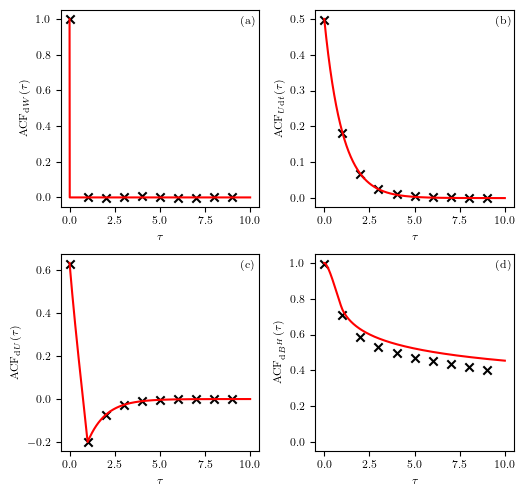

In [31]:
#Plotting Figure 2 in the main text with fGn.
fig, axs = plt.subplots(2,2,figsize=(5.3,5))

samplewidth = 2
samplecolor = "black"
theowidth = 1.5
theocolor = "red"



axs[0,0].set_ylabel(r"$\mathrm{ACF}_{\mathrm{d}W}(\tau)$")
axs[0,0].set_xlabel(r"$\tau$")
axs[0,0].text(0.91, 0.97, "(a)", transform=axs[0,0].transAxes, verticalalignment='top', bbox=props)
axs[0,0].scatter(lags, dw_sample_acf,color=samplecolor, marker="x")
axs[0,0].plot(lags_th, white_th_acf,color=theocolor,linewidth=theowidth)

axs[0,1].set_ylabel(r"$\mathrm{ACF}_{U\mathrm{d}t}(\tau)$")
axs[0,1].set_xlabel(r"$\tau$")
axs[0,1].text(0.91, 0.97, "(b)", transform=axs[0,1].transAxes, verticalalignment='top', bbox=props)
axs[0,1].scatter(lags, u_sample_acf,color=samplecolor, marker="x")
axs[0,1].plot(lags_th, u_th_acf,color=theocolor,linewidth=theowidth)

#axs[1,0].set_ylim([-0.0001,0.0001])
axs[1,0].set_ylabel(r"$\mathrm{ACF}_{\mathrm{d}U}(\tau)$")
axs[1,0].set_xlabel(r"$\tau$")
axs[1,0].text(0.91, 0.97, "(c)", transform=axs[1,0].transAxes, verticalalignment='top', bbox=props)
axs[1,0].scatter(lags, du_sample_acf,color=samplecolor, marker="x")
axs[1,0].plot(lags_th, du_th_acf,color=theocolor,linewidth=theowidth)

axs[1,1].set_ylabel(r"$\mathrm{ACF}_{\mathrm{d}B^H}(\tau)$")
axs[1,1].set_xlabel(r"$\tau$")
axs[1,1].text(0.91, 0.97, "(d)", transform=axs[1,1].transAxes, verticalalignment='top', bbox=props)
axs[1,1].scatter(lags, fGn_sample_acf,color=samplecolor, marker="x")
axs[1,1].plot(lags_th, fGn_th_acf,color=theocolor,linewidth=theowidth)
axs[1,1].set_ylim([-0.05,1.05])

fig.tight_layout()
plt.savefig("Plots/acfs.pdf",dpi=300, bbox_inches='tight')
plt.show()

## Simulate a fold bifurcation under Udt and dU noise

In [32]:
T = 10000
OneOverDelta_t = 1
Delta_t = 1/OneOverDelta_t
oversampling = 10
tspan = np.linspace(0,T,T*OneOverDelta_t*oversampling, endpoint = False)
tspan_plt = np.linspace(0,T,T*OneOverDelta_t, endpoint = False)
est_fraction = 0.7
stab_fraction = 0.8
theta = 1
kappa_u = 0.005
kappa_du = 0.0032

def alpha(t):
    #return np.sqrt(12)/9*t/(stab_fraction*T)
    #return np.heaviside(1-t/(stab_fraction*T),1)*np.sqrt(12)/9*1/3*(2+t/(stab_fraction*T))+(1-np.heaviside(1-t/(stab_fraction*T),1))*np.sqrt(12)/9
    return np.heaviside(1-t/(stab_fraction*T),1)*np.sqrt(12)/9*t/(stab_fraction*T)+(1-np.heaviside(1-t/(stab_fraction*T),1))*np.sqrt(12)/9


def f(x,t):
    return -x**3+x-alpha(t)

def V(x,alpha):
    return x**4/4-x**2/2+alpha*x

In [33]:
np.random.seed(0)
white_sample = np.random.normal(0, 1, size=T*OneOverDelta_t*oversampling)
u_sample = np.zeros(T*OneOverDelta_t*oversampling+1)
u_sample[0] = np.random.normal(0, sigma * math.sqrt(1/(2*theta)))
noise_fac = sigma * math.sqrt(1/(2*theta)*(1-math.exp(-2*theta*Delta_t/oversampling)))
for i in range(T*OneOverDelta_t*oversampling-1):
    u_sample[i+1] = math.exp(-theta*Delta_t/oversampling) * u_sample[i] + noise_fac*white_sample[i]

du_sample = np.diff(u_sample)
u_sample = u_sample[:-1]

In [34]:
if 1:
    n = T*OneOverDelta_t
    upper = np.zeros(n)
    lower = np.zeros(n)
    unstable = np.zeros(n)

    for i in range(n):
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,tspan_plt[i]),(0.0,50),[2.0], method="BDF")
        upper[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,tspan_plt[i]),(0.0,50),[-2.0], method="BDF")
        lower[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: -f(x,tspan_plt[i]),(0.0,50),[0.0], method="BDF")
        unstable[i] = sol.y[0,-1]
        
    unstable[np.abs(unstable)>1] = np.nan

In [35]:
x_u_sample = np.zeros(T*OneOverDelta_t*oversampling)
x_u_sample[0] = upper[0]
x_du_sample = np.zeros(T*OneOverDelta_t*oversampling)
x_du_sample[0] = upper[0]

for i in range(T*OneOverDelta_t*oversampling-1):
    x_u_sample[i+1] = x_u_sample[i] + f(x_u_sample[i],tspan[i])*Delta_t/oversampling + kappa_u*u_sample[i]*Delta_t/oversampling
    x_du_sample[i+1] = x_du_sample[i] + f(x_du_sample[i],tspan[i])*Delta_t/oversampling + kappa_du*du_sample[i]

x_u_sample = x_u_sample[::oversampling]
x_du_sample = x_du_sample[::oversampling]

In [36]:
windowsize = 1000
skip = 100
x_u_var = np.array([np.var(statsmodels.tsa.tsatools.detrend(x_u_sample[i:i+windowsize], order=2)) for i in range(0,T*OneOverDelta_t-windowsize,skip)])
x_du_var = np.array([np.var(statsmodels.tsa.tsatools.detrend(x_du_sample[i:i+windowsize], order=2)) for i in range(0,T*OneOverDelta_t-windowsize,skip)])
x_u_ac1 = np.array([np.dot(statsmodels.tsa.tsatools.detrend(x_u_sample[i:i+windowsize-1], order=2),statsmodels.tsa.tsatools.detrend(x_u_sample[i+1:i+windowsize], order=2))/np.var(statsmodels.tsa.tsatools.detrend(x_u_sample[i:i+windowsize], order=2))/windowsize for i in range(0,T*OneOverDelta_t-windowsize,skip)])
x_du_ac1 = np.array([np.dot(statsmodels.tsa.tsatools.detrend(x_du_sample[i:i+windowsize-1], order=2),statsmodels.tsa.tsatools.detrend(x_du_sample[i+1:i+windowsize], order=2))/np.var(statsmodels.tsa.tsatools.detrend(x_u_sample[i:i+windowsize], order=2))/windowsize for i in range(0,T*OneOverDelta_t-windowsize,skip)])

tau_u_var = round(stats.kendalltau(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_u_var[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)])[0],2)
tau_du_var = round(stats.kendalltau(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_du_var[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)])[0],2)
tau_u_ac1 = round(stats.kendalltau(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_u_ac1[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)])[0],2)
tau_du_ac1 = round(stats.kendalltau(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_du_ac1[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)])[0],2)

p_u_var = stats.linregress(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_u_var[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)])[0]
p_du_var = stats.linregress(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_du_var[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)])[0]
p_u_ac1 = stats.linregress(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_u_ac1[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)])[0]
p_du_ac1 = stats.linregress(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_du_ac1[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)])[0]

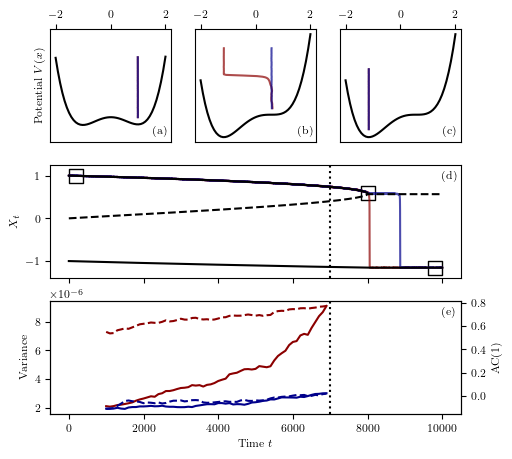

In [37]:
fig = plt.figure(figsize=(5.3,5))

gs = GridSpec(3, 3, figure=fig)
pot1plt = fig.add_subplot(gs[0, 0])
pot2plt = fig.add_subplot(gs[0, 1], sharey=pot1plt)
pot3plt = fig.add_subplot(gs[0, 2], sharey=pot1plt)
foldplt = fig.add_subplot(gs[1, :])
varplt = fig.add_subplot(gs[2, :], sharex=foldplt)
ac1plt = varplt.twinx()

staterange = np.linspace(-2,2,50)
t1 = 0.02*T
t2 = 0.8*T
t3 = 0.98*T
shortN = 100
x_alpha = 0.7

pot1plt.plot(staterange,[V(x,alpha(t1)) for x in staterange], c="black")
pot1plt.plot(x_u_sample[round(t1*OneOverDelta_t):round(t1*OneOverDelta_t)+shortN],np.linspace(0,2,shortN), c="darkred", alpha = x_alpha)
pot1plt.plot(x_du_sample[round(t1*OneOverDelta_t):round(t1*OneOverDelta_t)+shortN],np.linspace(0,2,shortN), c="darkblue", alpha = x_alpha)
pot1plt.xaxis.tick_top()
pot1plt.set_yticks([])
pot1plt.set_ylabel("Potential $V(x)$")
pot1plt.text(0.855, 0.15, "(a)", transform=pot1plt.transAxes, verticalalignment='top', bbox=props)


pot2plt.plot(staterange,[V(x,alpha(t2)) for x in staterange], c="black")
pot2plt.plot(x_u_sample[round(t2*OneOverDelta_t):round(t2*OneOverDelta_t)+shortN],np.linspace(0,2,shortN)+0.3, c="darkred", alpha = x_alpha)
pot2plt.plot(x_du_sample[round(t2*OneOverDelta_t):round(t2*OneOverDelta_t)+shortN],np.linspace(0,2,shortN)+0.3, c="darkblue", alpha = x_alpha)
pot2plt.xaxis.tick_top()
pot2plt.set_yticks([])
pot2plt.text(0.855, 0.15, "(b)", transform=pot2plt.transAxes, verticalalignment='top', bbox=props)

pot3plt.plot(staterange,[V(x,alpha(t3)) for x in staterange], c="black")
pot3plt.plot(x_u_sample[round(t3*OneOverDelta_t):round(t3*OneOverDelta_t)+shortN],np.linspace(0,2,shortN)-0.4, c="darkred", alpha = x_alpha)
pot3plt.plot(x_du_sample[round(t3*OneOverDelta_t):round(t3*OneOverDelta_t)+shortN],np.linspace(0,2,shortN)-0.4, c="darkblue", alpha = x_alpha)
pot3plt.xaxis.tick_top()
pot3plt.set_yticks([])
pot3plt.text(0.855, 0.15, "(c)", transform=pot3plt.transAxes, verticalalignment='top', bbox=props)

foldplt.plot(x_u_sample, c="darkred", alpha = x_alpha)
foldplt.plot(x_du_sample, c="darkblue", alpha = x_alpha)
foldplt.plot(tspan_plt[:round(stab_fraction*T*OneOverDelta_t)], upper[:round(stab_fraction*T*OneOverDelta_t)], c="black")
foldplt.plot(tspan_plt, unstable, c="black", linestyle="dashed")
foldplt.plot(tspan_plt, lower, c="black")
foldplt.scatter([t1], [upper[round(t1*OneOverDelta_t)]], facecolors='none', edgecolors="black", marker="s", s=100)
foldplt.scatter([t2], [upper[round(t2*OneOverDelta_t)]], facecolors='none', edgecolors="black", marker="s", s=100)
foldplt.scatter([t3], [lower[round(t3*OneOverDelta_t)]], facecolors='none', edgecolors="black", marker="s", s=100)
foldplt.axvline(est_fraction*T,c="black", linestyle="dotted")
plt.setp(foldplt.get_xticklabels(), visible=False)
foldplt.set_ylabel("$X_t$")
foldplt.text(0.955, 0.95, "(d)", transform=foldplt.transAxes, verticalalignment='top', bbox=props)
foldplt.set_ylim(-1.4,1.25)

varplt.plot(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_u_var[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)], c="darkred", linestyle="solid")
varplt.plot(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_du_var[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)], c="darkblue", linestyle="solid")
varplt.axvline(est_fraction*T,c="black", linestyle="dotted")
#varplt.axhline(kappa_du**2/(2*theta),c="darkblue", linestyle="solid")
varplt.set_ylabel("Variance")
varplt.set_xlabel("Time $t$")
#varplt.legend([tau_u_var, tau_du_var], loc="upper right")
#varplt.legend([p_u_var, p_du_var], loc="upper right")
ac1plt.plot(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_u_ac1[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)], c="darkred", linestyle="dashed")
ac1plt.plot(tspan_plt[windowsize:round(est_fraction*T*OneOverDelta_t):skip], x_du_ac1[:round((est_fraction*T*OneOverDelta_t-windowsize)/skip)], c="darkblue", linestyle="dashed")
#ac1plt.axhline(np.exp(-theta),c="darkblue", linestyle="dashed")
ac1plt.set_ylabel("AC(1)")
#ac1plt.legend([tau_u_ac1, tau_du_ac1], loc="lower right")
#ac1plt.legend([p_u_ac1, p_du_ac1], loc="lower right")
varplt.text(0.955, 0.95, "(e)", transform=varplt.transAxes, verticalalignment='top', bbox=props)

plt.savefig("Plots/tipping.pdf",dpi=300, bbox_inches='tight')
plt.show()